In [1]:
!gcloud config set project etsy-bigquery-adhoc-prod


If you have a compatible Python interpreter installed, you can use it by setting
the CLOUDSDK_PYTHON environment variable to point to it.

Updated property [core/project].


In [2]:
%load_ext google.cloud.bigquery

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Run the following in Bigquery
```
create table `etsy-sr-etl-prod.yzhang.visual_diversity_clipjoint_embedding` as (
  with train_data as (
    select distinct
        requestUUID, position, visitId,
        ctx.docInfo.queryInfo.query as query_str,
        ctx.docInfo.queryInfo.queryLevelMetrics.bin as query_bin,
        candidateInfo.docInfo.listingInfo.listingId as listing_id,
    from `etsy-ml-systems-prod.attributed_instance.query_pipeline_web_organic_2023_09_08`,
        unnest(contextualInfo) as ctx
    where ctx.docInfo.queryInfo.query is not null
    and candidateInfo.docInfo.listingInfo.listingId is not null
  ),
  embed_data as (
    select listing_id, joint_embedding_norm as embedding
    from `etsy-data-warehouse-prod.computer_vision.clip_joint_embeddings_latest`
    where listing_id in (
      select distinct listing_id from train_data
    )
  ),
  results as (
    select train_data.*, embed_data.embedding
    from train_data
    join embed_data
    on train_data.listing_id = embed_data.listing_id
  )
  select * from results  
)
```

Run dataflow job to get cosine sim

In [4]:
%%bigquery df
with query_gms as (
  select query, visit_id, sum(attributed_gms) as gms
  from `etsy-data-warehouse-prod.search.query_sessions_new`
  where _date = date('2023-09-08')
  group by query, visit_id
)
select clipj.*, gms
from `etsy-sr-etl-prod.yzhang.explore_visual_diversity_clipjoint` clipj
left join query_gms
on clipj.query_str = query_gms.query
and clipj.visitId = query_gms.visit_id
limit 900000

Downloading: 100%|██████████████████| 900000/900000 [03:25<00:00, 4386.39rows/s]


In [5]:
df.head(n=3)

,requestUUID,visitId,query_str,query_bin,listing_ids,cosine_sim,gms
0,26395cd4-b140-4d06-98e9-e99a2bb684ab,fQdZ8TKIiYm7BR8YFNgwFC_NUycG.1694201251764.1,adam and eve craft,None,"[1276393705, 1523056527, 1313388788, 567559147...","[1.0000000000000004, 0.759876446876194, 0.7103...",NaN
1,c0f7b19e-be74-4ce7-9293-633e1bd13343,_5si8_zmMgI7enIUq5Lp1tPmgjQR.1694184004995.1,raysin häuschen hochzeit,None,"[1473574066, 1526011895, 1387635675, 142556729...","[1.0, 0.7758412263212566, 0.7698515390108405, ...",NaN
2,86576600-a55d-485d-b81f-2da231c9cccf,pFCMErSaK0JpTwprO29JTu6Dy5Kl.1694146650323.1,cross pendant for men,None,"[1275005350, 943117771, 961024362, 1268485814,...","[1.0000000000000007, 0.8591017056690093, 0.870...",NaN


In [6]:
df.shape

(900000, 7)

In [7]:
df[~df.gms.isna()].shape

(488870, 7)

# Distribution of similarity scores

In [9]:
## Overall - sample 10000 requests
df_sub = df.sample(n=10000, replace=False).reset_index(inplace=False)

In [10]:
all_scores = []
for i in tqdm(range(10000)):
    d = int(np.sqrt(len(df_sub.cosine_sim[i])))
    sim_mat = np.reshape(np.copy(df_sub.cosine_sim[i]), (d, d))
    np.fill_diagonal(sim_mat, np.nan)
    sim_scores = sim_mat.flatten()
    all_scores.append(sim_scores)

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 22136.00it/s]


<Axes: ylabel='Count'>

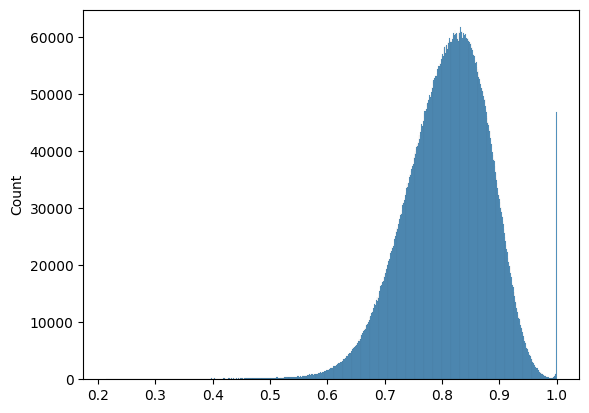

In [11]:
all_scores_flatten = np.concatenate(all_scores)
sns.histplot(all_scores_flatten)

In [12]:
## By query bin
df.query_bin.unique()

array([None, 'head', 'tail', 'top.1', 'torso', 'top.01'], dtype=object)

In [13]:
df_head = df[df.query_bin == "head"]; print(df_head.shape)
df_tail = df[df.query_bin == "tail"]; print(df_tail.shape)
df_torso = df[df.query_bin == "torso"]; print(df_torso.shape)
df_top1 = df[df.query_bin == "top.1"]; print(df_top1.shape)
df_top01 = df[df.query_bin == "top.01"]; print(df_top01.shape)

(264566, 7)
(55905, 7)
(73198, 7)
(163481, 7)
(190745, 7)


In [14]:
def get_sim_scores(data_df):
    all_scores = []
    for i in tqdm(range(data_df.shape[0])):
        d = int(np.sqrt(len(data_df.cosine_sim[i])))
        sim_mat = np.reshape(np.copy(data_df.cosine_sim[i]), (d, d))
        np.fill_diagonal(sim_mat, np.nan)
        sim_scores = sim_mat.flatten()
        all_scores.append(sim_scores[~np.isnan(sim_scores)])
    return np.concatenate(all_scores)

In [15]:
df_head_sub = df_head.sample(n=10000, replace=False).reset_index(inplace=False)
head_scores = get_sim_scores(df_head_sub)

df_tail_sub = df_tail.sample(n=10000, replace=False).reset_index(inplace=False)
tail_scores = get_sim_scores(df_tail_sub)

df_torso_sub = df_torso.sample(n=10000, replace=False).reset_index(inplace=False)
torso_scores = get_sim_scores(df_torso_sub)

df_top1_sub = df_top1.sample(n=10000, replace=False).reset_index(inplace=False)
top1_scores = get_sim_scores(df_top1_sub)

df_top01_sub = df_top01.sample(n=10000, replace=False).reset_index(inplace=False)
top01_scores = get_sim_scores(df_top01_sub)

100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 8926.08it/s]


In [16]:
print(np.min(top01_scores)); print(np.max(top01_scores))

0.19331520361651805
1.0000000000000018


In [17]:
print(np.min(head_scores)); print(np.max(head_scores))

0.1615183480267172
1.0000000000000018


In [18]:
print(np.min(tail_scores)); print(np.max(tail_scores))

0.18568483951855325
1.0000000000000018


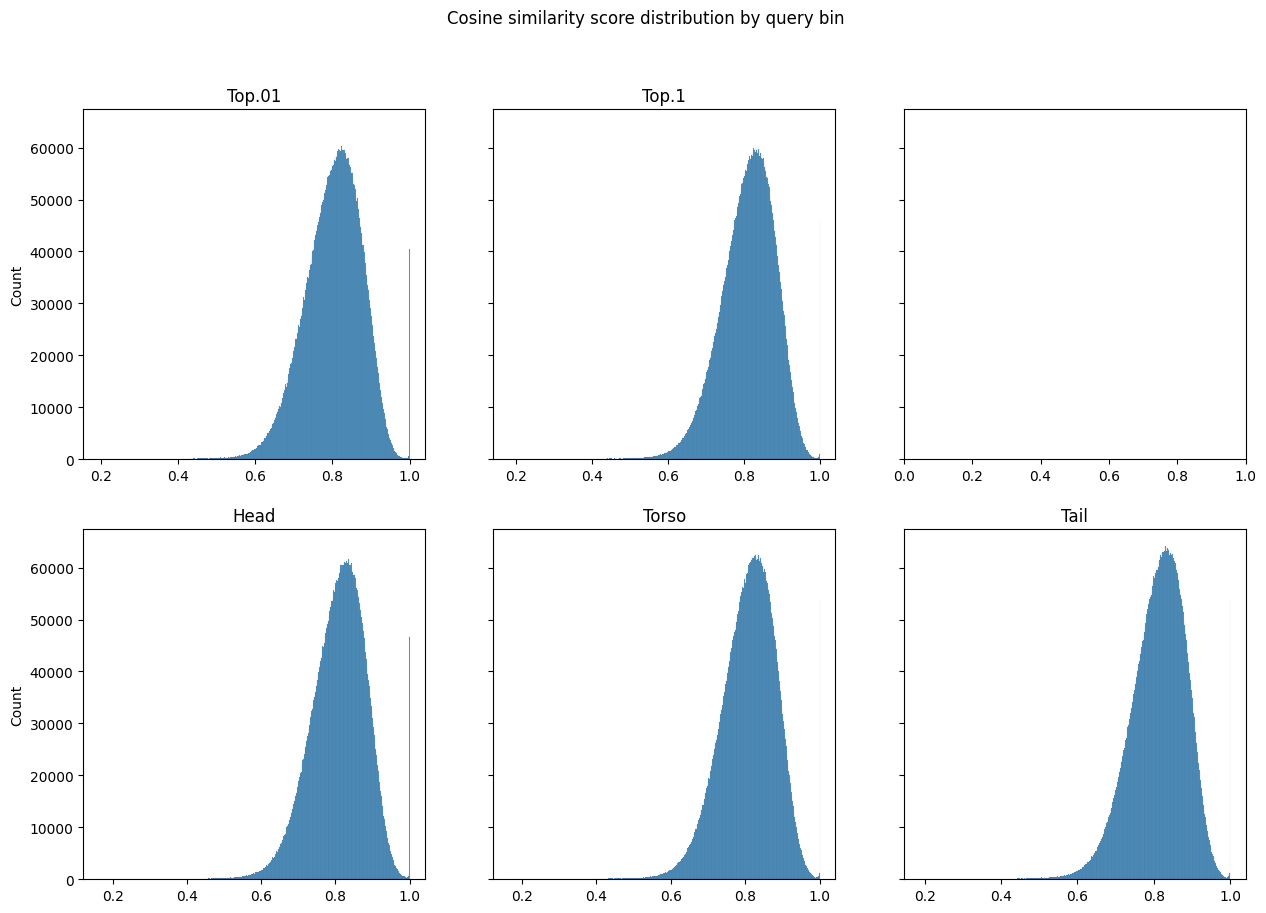

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
fig.suptitle('Cosine similarity score distribution by query bin')

sns.histplot(ax=axes[0, 0], data=top01_scores)
axes[0, 0].set_title("Top.01")

sns.histplot(ax=axes[0, 1], data=top1_scores)
axes[0, 1].set_title("Top.1")

sns.histplot(ax=axes[1, 0], data=head_scores)
axes[1, 0].set_title("Head")

sns.histplot(ax=axes[1, 1], data=torso_scores)
axes[1, 1].set_title("Torso")

sns.histplot(ax=axes[1, 2], data=tail_scores)
axes[1, 2].set_title("Tail")

plt.show()

# Threshold vs GMS

In [8]:
df_gms = df[~df.gms.isna()]
df_gms = df_gms[df_gms.gms > 0.]

In [9]:
df_gms[["query_str", "gms"]].drop_duplicates().gms.sum()

41707949.0

In [10]:
df_gms.shape

(25996, 7)

In [11]:
df_gms.reset_index(inplace=True)

In [12]:
thresholds = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]
threshold_queries = {str(th): set() for th in thresholds}

for i in tqdm(range(df_gms.shape[0])):
    
    d = int(np.sqrt(len(df_gms.cosine_sim[i])))
    sim_mat = np.reshape(np.copy(df_gms.cosine_sim[i]), (d, d))
    np.fill_diagonal(sim_mat, np.nan)
    sim_scores = sim_mat.flatten()
    offdiag_sim_scores = sim_scores[~np.isnan(sim_scores)]
    
    for k, v in threshold_queries.items():
        if np.any(offdiag_sim_scores > (1. - float(k))):
            threshold_queries[k].add(df_gms.query_str[i])

100%|███████████████████████████████████| 25996/25996 [00:03<00:00, 6994.66it/s]


In [13]:
query_gms_only = df_gms[["query_str", "gms"]].drop_duplicates()

In [14]:
threshold_gms = {k: query_gms_only[query_gms_only.query_str.isin(threshold_queries[k])].gms.sum() for k in threshold_queries.keys()}
threshold_gms

{'0.0001': 1421357.0,
 '0.001': 3294896.0,
 '0.01': 10451976.0,
 '0.05': 31166623.0,
 '0.1': 40900392.0,
 '0.2': 41668767.0}

# How discriminative are the scores

Sample 20 pairs of listings with sim score > thresholds

In [27]:
df_sampled = df.sample(n=10000, replace=False).reset_index(inplace=False)

In [28]:
thresholds = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]
threshold_listings = {str(th): set() for th in thresholds}

for i in tqdm(range(df_sampled.shape[0])):
    d = int(np.sqrt(len(df_sampled.cosine_sim[i])))
    sim_mat = np.reshape(np.copy(df_sampled.cosine_sim[i]), (d, d))
    cand_listings = list(df_sampled.listing_ids[i])
    np.fill_diagonal(sim_mat, np.nan)
    
    for j in range(d):
        for k in range(j+1, d):
            for key, val in threshold_gms.items():
                if (sim_mat[j, k] > (1.0 - float(key))) and (cand_listings[j] != cand_listings[k]):
                    threshold_listings[key].add((cand_listings[j], cand_listings[k]))

100%|████████████████████████████████████| 10000/10000 [00:22<00:00, 442.08it/s]


In [29]:
[len(v) for v in threshold_listings.values()]

[15, 306, 2224, 36953, 434482, 2990593]

In [30]:
for key, val in threshold_listings.items():
    print(key)
    val = list(val)
    sampled_idx = np.random.choice(len(val),size=20)
    sampled_val = [val[idx] for idx in sampled_idx]
    for i in range(len(sampled_val)):
        lid1 = sampled_val[i][0]
        lid2 = sampled_val[i][1]
        print(f"https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids={lid1},{lid2}")

0.0001
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=115910641,115911251
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1471034634,1485228131
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1379976073,625823365
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1523311750,1537531311
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1430033779,1436387872
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1496868041,1482677686
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=839003025,840534231
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1489019206,1489131436
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1461708003,1447506566
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1471034634,1485228131
https://atlas.etsycorp.com/recsys/listing_viewer.php?listing_ids=1120268759,1120270757
https://atlas.etsycorp.com/recsys/listing